# Trabajo con imágenes

Por:

* Fernando Gómez Perera - 160300129@ucaribe.edu.mx
* Ricardo Vargas Kumul- 170300227@ucaribe.edu.mx
* Calvin López Álvarez - 170300226@ucaribe.edu.mx

In [1]:
# Bibliotecas a usar
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp

## Artículos a replicar

Los artículos que usamos como referencia para desarrollar los proyectos son los siguientes:

* ***An improved GVF snake based breast region extrapolation scheme for digital mammograms*** de *Liu et al*.: El objetivo de este artículo es extrapolar la región del busto usando un esquema mejorado de una serpiente Flujo del Vector Gradiente o *Gradient Vector Flow (GVF) snake*.
*  ***A pectoral muscle segmentation algorithm for digital mammograms using Otsu thresholding and multiple regression analysis*** de *Liu et al*: El objetivo de este artículo es segmentar la región del músculo pectoral de la región del pecho combinando el esquema de umbralización de Otsu y el procesamiento matemático morfológico para obtener un borde del músculo pectoral, y usar el análsis de regresión múltiple (*MRA*) para obtener una segmentación precisa del mismo.

## Primera parte: Extrapolación de la región del busto

Para llevarl a cabo, tomamos como referencia el primer artículo de *Liu et al*. [[1]](#ref) En este artículo, los autores proponen un esquema mejorado de una serpiente Flujo del Vector Gradiente o *Gradient Vector Flow (GVF) snake* para poder extrapolar toda la región del busto. Este esquema o algoritmo que ellos proponen es el siguiente:

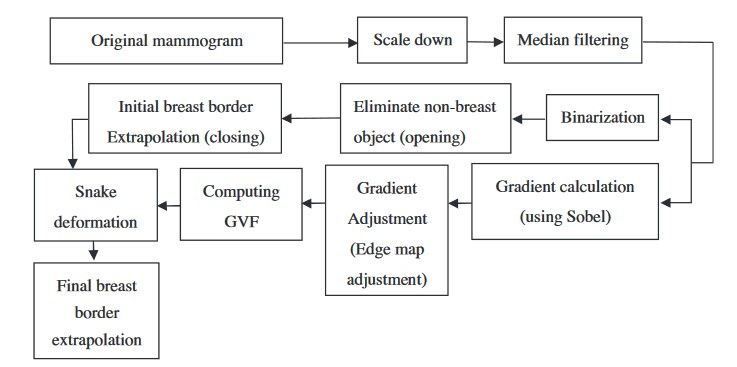

1. Reescalar las imágenes originales de las mamografías.
2. Aplicar un filtro de mediana a las imágenes reescaladas.

En este punto, el proceso se divide en 2 fase:

3. Binarizar la imagen reescalada.
4. Eliminar los objetos que no son de la región del busto.
5. Obtener une extrapolación inicial del borde del busto.

Paralelamente:

3. Aplicar un filtro de Sobel para obtener el campo gradiente de la mamografía reescalada.
4. Ajustar el campo gradiente.
5. Calcular el Flujo del Vector Gradiente (*GVF*).

En este punto, ambos procesos se unen:

6. Aplicar la deformación serpiente usando el *GVF* calculado sobre la extrapolación inicial del borde del busto.
7. Obtener la extrapolación final del borde del busto.

### Tarea 1

#### 2. Replica un proceso de limpieza del fondo de la imagen

Este proceso sigue la primera ramificación del algoritmo propuesto por los autores.

Primero, se importan al entorno todas las imágenes originales.

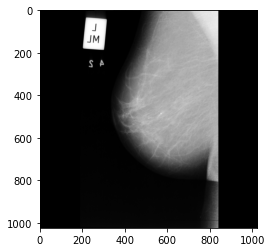

In [2]:
# Ruta de las imágenes originales
base_dir = '../extdata/all-mias/'
all_filenames = os.listdir(base_dir)
imgs_filenames = list()

# Extraer los archivos que corresponden a las imágenes de las mamografías
for filename in all_filenames:
    if filename.endswith('.pgm'):
        imgs_filenames.append(filename)
        
# Reordernar las imágenes alfabéticamente/numéricamente
imgs_filenames.sort()

# Lectura de las imágenes con el parámetro -1 para leer la imagen sin modificar
imgs_orig = list(map(lambda img_name: cv.imread(base_dir+img_name, 0), imgs_filenames))

# Imagen de ejemplo
plt.imshow(imgs_orig[10], cmap='gray')
plt.show()

El artículo tiene varias partes que se contradicen entre sí. Al principio del artículo, los autores mencionan que **primero** se aplica el filtro de mediana sobre las mamografías originales y **después** el reescalamiento de las mamografías. Sin embargo, en el primer diagrama de flujo se puede notar que estos pasos están invertidos.

Hemos probado ambas formas, y llegamos a la conclusión que se obtienen mejores resultados si **primero** se aplica el filtro de mediana y **después** el reescalamiento de las imágenes. Así que estos pasos se llevan a cabo en ese orden.

##### 2.1 Aplicar el filtro de mediana

Los autores sugieren aplicar un filtro de mediana de 3 x 3 pixeles para reducir el ruido de la imagen.

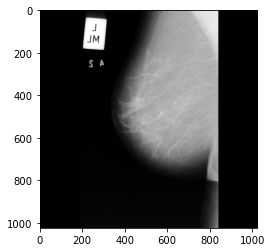

In [3]:
# Aplicar un filtro de mediana a cada una de las imágenes
imgs_filter = list(map(lambda img_orig: cv.medianBlur(img_orig, 3), imgs_orig))

# Imagen de ejemplo
plt.imshow(imgs_filter[10], cmap='gray')
plt.show()

##### 2.2 Reescalar la imagen

Las mamografías se reescalan para hacerlas más pequeñas. Esto permitirá ahorrar tiempo en la ejecución del resto del proceso.

Para mantener la calidad de la extrapolación, los autores sugieren reescalar las imágenes originales de 1024 x 1024 pixeles a 256 x 256 pixeles.

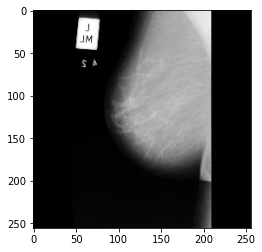

In [4]:
# Reescalar las imágenes para hacerlas más pequeñas (scale down)
imgs_scale = list(map(lambda img_filter: cv.resize(img_filter, (256, 256)), imgs_filter))

# Imagen de ejemplo
plt.imshow(imgs_scale[10], cmap='gray')
plt.show()

##### 2.3 Binarización de las imágenes

Este paso permite obtener un contorno aproximado. Para ello, los autores proponen obtener un umbrarl $T$, el cual será equivalente al valor medio de gris de la imagen.

La fórmula para calcular el umbral $T$ es la siguiente:

$$T = 0.2 \cdot  \frac{\sum_{n = 0}^{255} n \cdot H(n)}{\sum_{n = 0}^{255} H(n)}$$

donde $n$ es el valor del nivel de gris, el cual va de 0 a 255, y $H(n)$ es el número de pixeles con el valor de pixel $n$ dentro de la imagen, el cual se obtiene de su histograma.

Para binarizarla, se sigue la siguiente fórmula:

$$
IB(x, y)  = \begin{cases}
    1,\text{ si } I(x,y) \geq T,\\
    0, \text{ de otra forma}.
  \end{cases}
$$

donde $I(x, y)$ es el valor de intensidad de cada pixel en la imagen.

De esta forma, la imagen quedará divida en la región de fondo (con valor de pixel 0) y la región de objetos (con valor de pixel 1).

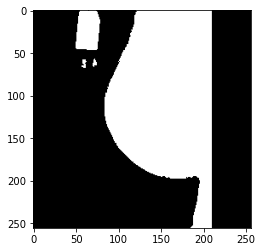

In [5]:
# Obtener del umbral a partir del valor del nivel de gris en la imagen
def T(img):
    H_n = cv.calcHist([img], [0], None, histSize=[256], ranges=(0, 256), accumulate=False).ravel()
    return 0.2 * np.sum(np.arange(0, 256) * H_n) / np.sum(H_n)

# Binarizar la imagen
def binarization(img):
    return np.where(img >= T(img), 1, 0).astype(np.uint8)

# Binarización de las imágenes
imgs_bin = list(map(lambda img_scale: binarization(img_scale), imgs_scale))

# Imagen de ejemplo
plt.imshow(imgs_bin[10], cmap='gray')
plt.show()

##### 2.4 Eliminar los objetos que no son parte de la región del busto.

Este proceso está compuesto de 2 partes:

###### 2.4.1 Procesamiento morfológico

Tomando como base el ejemplo de la imagen binarizada, se puede notar que además de la región del busto, hay pequeñas regiones que no son de interés. Para eliminarlos, los autores proponen en su algoritmo aplicar la operación morfológica de apertura, la cual está compuesta de 2 transformaciones morfológicas:

* La **erosión**, la cual, como dice su nombre, erosiona los límites del objeto en primer plano (siempre trata de mantener el primer plano en blanco).
* La **dilatación**, que es lo opuesto a la erosión. Esto provoca que aumente la región blanca en la imagen o aumente el tamaño del objeto en primer plano.

Para ello, la función toma un kernel que se desliza por la imagen, y modfica el valor de un pixel de acuerdo con los siguientes criterios:

* En el caso de la **erosión**, el valor del pixel será de 1 solamente si todos los pixeles bajo el kernel son 1. Sino, se erosiona (se vuelve 0).
* En el caso de la **dilatación**, el valor del pixel será de 1 si al menos un pixel bajo el kernel es de 1.

Los autores proponen usar un elemento estructurado (kernel) formado por un disco de radio 2 pixeles.

In [6]:
# Creación del kernel compuesto por un disco de radio 2
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0
kernel

array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

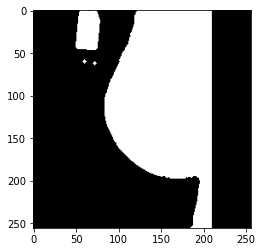

In [7]:
# Aplicar el procesamiento morfológico de apertura sobre las imágenes binarizadas
imgs_mpo = list(map(lambda img_bin: cv.morphologyEx(img_bin, cv.MORPH_OPEN, kernel), imgs_bin))

# Imagen de ejemplo
plt.imshow(imgs_mpo[10], cmap='gray')
plt.show()

Aún después de aplicar esta operación, y como se visualiza en la imagen de ejemplo, aún quedan elementos que no corresponden al área del busto. Sin embargo, claramente se puede notar que su tamaño es menor en comparación al área del busto.

Por ello, para eliminar los elementos faltantes, los autores proponen usar las características del objeto busto en la imagen mamográfica para etiquetar los objetos, y después extraer el objeto de mayor tamaño de la imagen binarizada. Y aquellos objetos que no correspondan al área del busto se modifican para volverse parte del fondo en dicha imagen. Finalmente, estos objetos también se modifican en la imagen reducida $I$, estableciendo sus valores de intensidad igual al nivel de gris medio del área que no pertenece al área del busto en $I$.

Sin embargo, los autores no explican cómo llevaron a cabo este proceso. Por lo que nosotros implementamos un proceso que busca replicar los puntos que ellos mencionan.

Este proceso se compone de los siguientes pasos, aplicados a cada mamografía:

1. Obtener los contornos de los objetos en la imagen binarizada ya modificada por el procesamiento morfológico de apertura.
3. Tomar el contorno del objeto más grande, que corresponde a la región del busto.
4. Crear una nueva imagen binarizada pintando solamente la región del objeto más grande.
5. Limpiar la mamografía, estableciendo las intensidades de los objetos que no son parte de la región del busto con el valor del nivel de gris medio del área que no pertenece al busto.

In [8]:
# Obtener el contorno del objeto más grande en la imagen binarizada procesada
def get_max_contour(img_mpo):
    contours, _ = cv.findContours(img_mpo, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Se obtiene el contorno del objeto más grande
    return [max(enumerate(contours), key = lambda tup: len(tup[1]))[1]]

"""Obtener los objetos que no son la región del busto en la
imagen binarizada original"""
def get_non_breast_objs(img_bin):
    contours, _ = cv.findContours(img_bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # Se obtiene el índice del contorno del objeto más grande
    ind_max_contour = max(enumerate(contours), key = lambda tup: len(tup[1]))[0]
    # Se elimina el índice del objeto más grande
    del contours[ind_max_contour]
    # Obtener las regiones de estos objetos
    new_img_bin = np.zeros(img_bin.shape).astype(img_bin.dtype)
    cv.fillPoly(new_img_bin, contours, 1)
    return new_img_bin

"""Obtener dos nuevas imágenes binarizadas destacando en ambos casos solamente
el objeto de mayor tamaño (la región del busto)"""
def clean_img_mpo(img_mpo):
    new_img_bin = np.zeros(img_mpo.shape).astype(img_mpo.dtype)
    new_inv_img_bin = np.ones(img_mpo.shape).astype(img_mpo.dtype)
    max_contour = get_max_contour(img_mpo)
    # Obtener la nueva imagen binarizada y su inversa
    cv.fillPoly(new_img_bin, max_contour, 255)
    cv.fillPoly(new_inv_img_bin, max_contour, 0)
    return new_img_bin, new_inv_img_bin

# Obtener una nueva mamografía eliminando los objetos que no son parte de la región del busto
def get_breast_region(img_scale, img_bin, img_mpo):
    # Limpiar la imagen binarizada preprocesada
    new_img_bin, new_inv_img_bin = clean_img_mpo(img_mpo)
    # Obtener las intensidades del área que no pertenece a la región del busto
    non_breast_values = img_scale * new_inv_img_bin
    # Calcular el nivel de gris medio de estas áreas
    mean_gray_level = np.mean(non_breast_values)
    # Modificar las intensidades de estas regiones con este valor
    img_mean_gray_level = mean_gray_level * get_non_breast_objs(img_bin)
    new_img_scale = np.where(img_mean_gray_level == mean_gray_level, img_mean_gray_level, img_scale).astype(np.uint8)
    return new_img_scale, new_img_bin

In [9]:
# Eliminar los objetos que no son parte de la región del busto en las imágenes escaladas
clean_imgs = list()
clean_imgs_bin = list()

for img_scale, img_bin, img_mpo in zip(imgs_scale, imgs_bin, imgs_mpo):
    clean_img, clean_img_bin = get_breast_region(img_scale, img_bin, img_mpo)
    clean_imgs.append(clean_img)
    clean_imgs_bin.append(clean_img_bin)

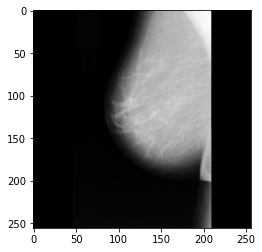

In [10]:
# Imagen de ejemplo (Imagen escalada limpia)
plt.imshow(clean_imgs[10], cmap='gray')
plt.show()

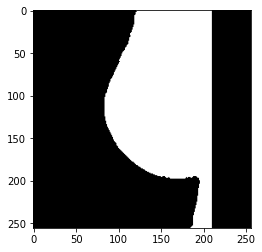

In [11]:
# Imagen de ejemplo (Imagen binarizada limpia)
plt.imshow(clean_imgs_bin[10], cmap='gray')
plt.show()

Finalmente, todas las imágenes limpias se almacenan en el directorio de la aplicación para que puedan usarse dentro de ella.

In [12]:
# Almacenar las mamografías limpias en la carpeta de la aplicación
app_dir = '../app/img/'
# Obtener los números de imagen en el orden en el que se importaron al entorno
find_nums = re.compile('\d{3}')
imgs_nums = list(map(lambda filename: int(find_nums.findall(filename)[0]), imgs_filenames))

for img_scale, img_clean, img_bin, img_num in zip(imgs_scale, clean_imgs, clean_imgs_bin, imgs_nums):
    cv.imwrite(app_dir + str(img_num) + '_scale.png', img_scale)
    cv.imwrite(app_dir + str(img_num) + '_clean.png', img_clean)
    cv.imwrite(app_dir + str(img_num) + '_bin_clean.png', img_bin)

## Tarea 2

### 3. Replica un proceso que elimine el músculo pectoral

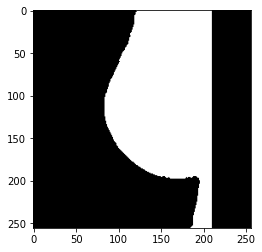

In [31]:
img_test = clean_imgs_bin[10]

plt.imshow(img_test, cmap='gray')
plt.show()

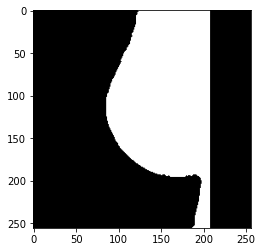

In [32]:
img_ero = cv.erode(img_test, kernel, iterations=1)

plt.imshow(img_ero, cmap='gray')
plt.show()

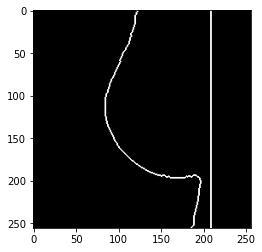

In [33]:
img_edges = img_test - img_ero

plt.imshow(img_edges, cmap='gray')
plt.show()

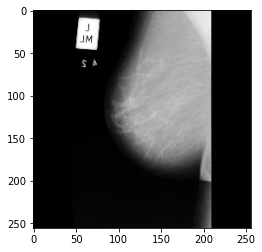

In [34]:
plt.imshow(imgs_scale[10], cmap='gray')
plt.show()

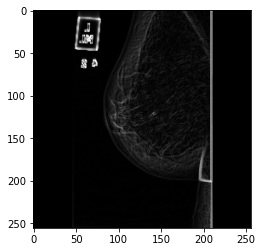

In [35]:
# Prueba con el filtro de Sobel
grad_x = cv.Sobel(imgs_scale[10], cv.CV_64F, dx=1, dy=0)
grad_y = cv.Sobel(imgs_scale[10], cv.CV_64F, dx=0, dy=1)

abs_grad_x = cv.convertScaleAbs(grad_x)
abs_grad_y = cv.convertScaleAbs(grad_y)

grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.imshow(grad, cmap='gray')
plt.show()

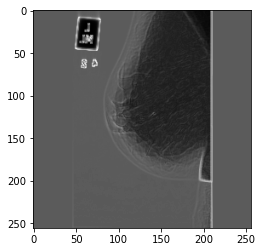

In [36]:
w0 = 0.63
w1 = 1 - w0

G_adj = w0 * ((grad - np.min(grad)) / (np.max(grad) - np.min(grad))) + w1 * ((T(imgs_scale[10]) - imgs_scale[10]) / 255)

plt.imshow(G_adj, cmap='gray')
plt.show()

In [37]:
fx = cv.Sobel(imgs_scale[10], cv.CV_64F, dx=1, dy=0)
fx = cv.convertScaleAbs(fx)
fy = cv.Sobel(imgs_scale[10], cv.CV_64F, dx=0, dy=1)
fy = cv.convertScaleAbs(fy)

u = fx.copy()
v = fy.copy()

lamb = 0.1

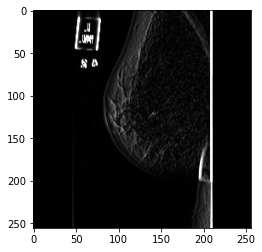

In [38]:
plt.imshow(fx, cmap='gray')
plt.show()

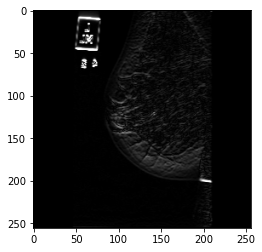

In [39]:
plt.imshow(fy, cmap='gray')
plt.show()

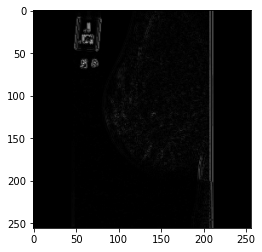

In [40]:
for i in range(1):
    u = lamb * cv.Laplacian(u, cv.CV_64F) - (u - fx) * (fx*+2 + fy**2)
    u = cv.convertScaleAbs(u)

for i in range(1):
    v = lamb * cv.Laplacian(v, cv.CV_64F) - (v - fy) * (fx*+2 + fy**2)
    v = cv.convertScaleAbs(v)
    
#u = cv.convertScaleAbs(u)
#v = cv.convertScaleAbs(v)
    
plt.imshow(u, cmap='gray')
plt.show()

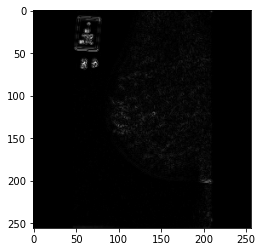

In [41]:
plt.imshow(v, cmap='gray')
plt.show()

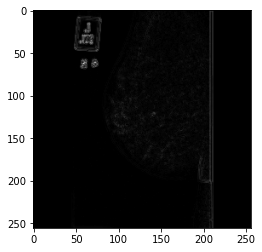

In [42]:
V = cv.addWeighted(u, 0.5, v, 0.5, 0)

plt.imshow(V, cmap='gray')
plt.show()

In [43]:
X_s = img_edges.copy()
alpha = 0.001
beta = 0.001

for i in range(5):
    X_s_2 = cv.Laplacian(X_s, cv.CV_64F)
    X_s_4 = cv.Laplacian(X_s_2, cv.CV_64F)
    X_s_2 = cv.convertScaleAbs(X_s_2)
    X_s_4 = cv.convertScaleAbs(X_s_4)
    X_s = alpha * X_s_2 - beta * X_s_4 + V

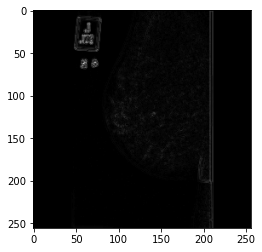

In [44]:
plt.imshow(X_s, cmap='gray')
plt.show()

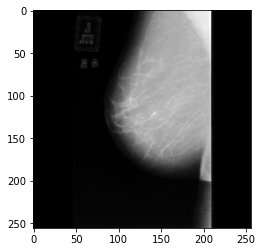

In [45]:
X = clean_imgs[10] + X_s

plt.imshow(X, cmap='gray')
plt.show()

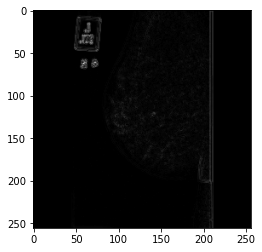

In [46]:
grad = cv.addWeighted(u, 0.5, v, 0.5, 0)

plt.imshow(grad, cmap='gray')
plt.show()

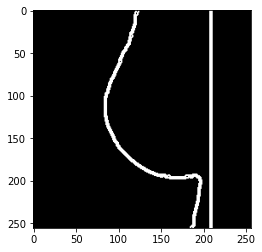

In [47]:
x = img_test
alpha = 0.1
beta = 0.1

for i in range(20):
    x_1 = cv.Sobel(img_edges, cv.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    y_1 = cv.Sobel(img_edges, cv.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    
    x_1 = cv.convertScaleAbs(x_1)
    y_1 = cv.convertScaleAbs(y_1)
    
    grad = cv.addWeighted(x_1, 1, y_1, 1, 0)
    grad_2 = cv.Laplacian(img_edges, cv.CV_16S, 3)
    grad_2 = cv.convertScaleAbs(grad_2)
    
    x = alpha * grad_2 - beta * grad_2+grad
    
plt.imshow(x, cmap='gray')
plt.show()

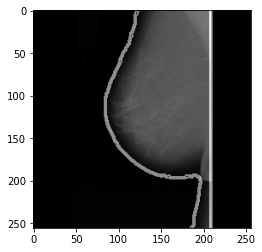

In [48]:
X = clean_imgs[10] + x

plt.imshow(X, cmap='gray')
plt.show()

In [ ]:
x

In [ ]:
?cv.threshold

In [ ]:
bin_x = cv.threshold(X.astype(np.uint8),0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]

plt.imshow(bin_x, cmap='gray')
plt.show()

In [ ]:
x_mpo = cv.morphologyEx(bin_x, cv.MORPH_OPEN, kernel)

# Imagen de ejemplo
plt.imshow(x_mpo, cmap='gray')
plt.show()

In [ ]:
bin_x = cv.threshold(x_mpo,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
x_mpo = cv.morphologyEx(bin_x, cv.MORPH_OPEN, kernel)

plt.imshow(x_mpo, cmap='gray')
plt.show()

In [ ]:
bin_x = cv.threshold(x_mpo,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
x_mpo = cv.morphologyEx(bin_x, cv.MORPH_OPEN, kernel)

plt.imshow(x_mpo, cmap='gray')
plt.show()

In [ ]:
bin_x

In [62]:
# tamaño de la imagen
N = 256 * 256

# Sacamos el threshold de la imagen nuevmaente
threshold = T(clean_imgs[10])

# especificamos que trabajaremos sobre 'l'
l = sp.Symbol('l')

# valores minimos y maximos de la imagen
l_min = np.min(clean_imgs[10])
l_max = np.max(clean_imgs[10])

n_l = list(clean_img[10].flatten()).count(l)

w_1 = (1/N) * sp.integrate(n_l,(l,l_min,threshold))
w_2 = w_1 - 1

print(w_1)
print(w_2)

0
-1


1. aplicar la binarizacion anterior con el nuevo threshold de obtenido con otsu
2. usar el mismo kernel de radio 2 pero con morphological opening (es una de las 4 transformaciones)
3. hacer lo mismo que en el anterior donde al original se le restaba el erosionado para obtener el nuevo

## 1

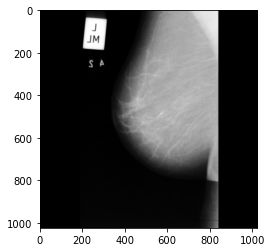

In [13]:
# Aplicar un filtro de mediana a cada una de las imágenes
imgs_gauss = list(map(lambda img_orig: cv.GaussianBlur(img_orig, (5, 5), 0), imgs_orig))

# Imagen de ejemplo
plt.imshow(imgs_gauss[10], cmap='gray')
plt.show()

In [18]:
# Establecemos el numero de bins in el histograma
bins_num = 256

# Sacamos el histograma de la imagen
hist, bin_edges = np.histogram(imgs_gauss[10], bins=bins_num)

# Normalizamos el histograma
hist = np.divide(hist.ravel(), hist.max())

# Calculamos el centro
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iteramos sobre todos los umbrales y conseguimos las probabilidades w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Computamos la clase media mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Computamos la clase media mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximizamos el valor de la función inter_class_variance
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print(threshold)

82.107421875


82.0


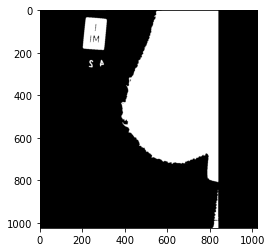

In [20]:
otsu_threshold, image_result = cv.threshold(imgs_gauss[10], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU,)
print(otsu_threshold)

plt.imshow(image_result, cmap='gray')
plt.show()

### Serpientes clásicas en la segmentación de imágenes

Llamadas también como *modelo activo del contorno*, permite obtener una curva deformable en el dominio espacial de la imagen minimizando una función de energía. La forma de la serpiente es modificada por las fuerzas internas que intentan mantener la suavidad de la forma de la serpiente, y también es modificada por las fuerzas externas que atraen a la serpiente hacia las característica destacadas de la imagen.

Este modelo tiene 2 incovenientes:

1. La serpiente inicial debe estar bastante cerca del límite verdadero.
2. El contorno activo no puede deformarse fácilmente en puntos de contorno cóncavos.

### Serpiente *GVF*

Es una mejora del modelo clásico de serpíente., con el objetivo de obtener un mejor rendimiento en la segmentación de imágenes.

La idea detrás de este modelo es agrandar el rango de influencia de cada fuerza externa creando un campo del flujo del vector gradientepara sustituir el cambo de fuerzas externas de la serpiente clásica.

Este modelo mejora el rango restringido de captura y la débil convergencia de la serpiente clásica. Pero aún depende de la distribución del gradiente de la imagen.

## <a name="ref"></a>  Referencias

Liu, C.-C., Tsai, C.-Y., Tsui, T.-S., & Yu, S.-S. (2012). An improved GVF snake based breast region extrapolation scheme for digital mammograms. Expert Systems with Applications, 39(4), 4505-4510. https://doi.org/10.1016/j.eswa.2011.09.136

Liu, C.-C., Tsai, C.-Y., Liu, J., Yu, C.-Y., & Yu, S.-S. (2012). A pectoral muscle segmentation algorithm for digital mammograms using Otsu thresholding and multiple regression analysis. Computers & Mathematics with Applications, 64(5), 1100-1107. https://doi.org/10.1016/j.camwa.2012.03.028

OpenCV. (2021, 9 marzo). OpenCV: Morphological Transformations. https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html